## Wine predictive analysis

This analysis is based on a dataset of 1599 red wine samples, found [here](https://archive.ics.uci.edu/dataset/186/wine+quality)

In this analysis we will focus on:

- Are wines of different quality levels differing in alcohol content? In other words, is there a relation between alcohol level and quality of wine?
- How well can we predict quality of a wine from alcohol level, and from a set of physicochemical components? (purpose)
- Which combination of physicochemical components of a wine is best at predicting how much alcohol a wine contains?


In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor, OLSInfluence
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
    roc_curve,
    roc_auc_score,
)
from imblearn.over_sampling import SMOTE

In [2]:
sns.set_style("white")
sns.set_palette("ch:.25")
warnings.filterwarnings("ignore")

In [3]:
# Disable scientific notification in the entire notebook
pd.set_option("display.float_format", lambda x: "%.2f" % x)

# Display floats only with 3 decimals in the entire notebook
pd.options.display.float_format = "{:,.3f}".format

## Part 1: Data exploration

In [4]:
wine = pd.read_csv("/content/drive/MyDrive/colab_data_sources/winequality-red.csv")
print(
    "There are {} rows and {} columns in this dataset.".format(
        wine.shape[0], wine.shape[1]
    )
)

There are 1599 rows and 12 columns in this dataset.


In [5]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.400,0.700,0.000,1.900,0.076,11.000,34.000,0.998,3.510,0.560,9.400,5
1,7.800,0.880,0.000,2.600,0.098,25.000,67.000,0.997,3.200,0.680,9.800,5
2,7.800,0.760,0.040,2.300,0.092,15.000,54.000,0.997,3.260,0.650,9.800,5
3,11.200,0.280,0.560,1.900,0.075,17.000,60.000,0.998,3.160,0.580,9.800,6
4,7.400,0.700,0.000,1.900,0.076,11.000,34.000,0.998,3.510,0.560,9.400,5


#### Feature definitions
Since there are a lot of features that do not speak to the imagination unless you are a wine expert, first an overview of definitions for later reference (source chatgtp):

* Fixed Acidity: This is the total concentration of non-volatile acids (e.g., tartaric, malic, and citric acids) in the wine. It contributes to the overall sourness or acidity of the wine.
* Volatile Acidity: This represents the amount of acetic acid in the wine. It is called "volatile" because these acids can easily evaporate into the air, creating a pungent vinegary aroma. High levels of volatile acidity can result in a vinegar-like taste and are generally undesirable.  
* Citric Acid: This is one of the three main fixed acids in wine (along with tartaric and malic acids).
* pH: pH measures the acidity or alkalinity of the wine. It can impact the taste and stability of the wine. Typically, wines have a pH between 3 and 4.
* Residual Sugar: This is the amount of sugar that remains in the wine after fermentation. It contributes to the wine's sweetness.
* Chlorides: The chloride content in wine, specifically sodium chloride, can affect the wine's taste and mouthfeel.
* Density: is a measure of its mass per unit volume. It is often used to assess the concentration of wine or its sugar content. Wine density is related to factors like sugar levels, alcohol content, and dissolved solids. The density of the wine is an important property used to determine the alcohol content.
* Sulphates: Sulfur dioxide is often added to wine as a preservative and for preventing spoilage. The term "sulphates" in wine analysis usually refers to the measurement of sulfur dioxide levels.
* Free Sulfur Dioxide: Sulfur dioxide is used in winemaking as a preservative and for its antioxidant properties. The "free" form of sulfur dioxide is the portion that is not bound to other compounds and is available for protection.
* Total Sulfur Dioxide: This includes both the free and bound forms of sulfur dioxide. It's a measure of the total sulfur dioxide content in the wine.



At first sulphates and total sulful dioxide sound like the same thing, however after a quick search we find that they are different components: "sulphates" refer to a measurement of sulfate ions, while "total sulfur dioxide" encompasses the total concentration of sulfur dioxide.

At first sight it seems like some features are more related to flavour, some to preserving, acidity, and some perhaps to both.

In [6]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [7]:
wine.columns = wine.columns.str.replace(r" ", "_", regex=True).str.lower()
wine.columns

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'ph', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [8]:
full_duplicates = wine.duplicated().sum()
print("There are", full_duplicates, "fully duplicated cases.")

There are 240 fully duplicated cases.


In [9]:
duplicate_rows = wine[wine.duplicated(keep=False)]
duplicate_rows

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
0,7.400,0.700,0.000,1.900,0.076,11.000,34.000,0.998,3.510,0.560,9.400,5
4,7.400,0.700,0.000,1.900,0.076,11.000,34.000,0.998,3.510,0.560,9.400,5
9,7.500,0.500,0.360,6.100,0.071,17.000,102.000,0.998,3.350,0.800,10.500,5
11,7.500,0.500,0.360,6.100,0.071,17.000,102.000,0.998,3.350,0.800,10.500,5
22,7.900,0.430,0.210,1.600,0.106,10.000,37.000,0.997,3.170,0.910,9.500,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1567,7.200,0.695,0.130,2.000,0.076,12.000,20.000,0.995,3.290,0.540,10.100,5
1579,6.200,0.560,0.090,1.700,0.053,24.000,32.000,0.994,3.540,0.600,11.300,5
1581,6.200,0.560,0.090,1.700,0.053,24.000,32.000,0.994,3.540,0.600,11.300,5
1592,6.300,0.510,0.130,2.300,0.076,29.000,40.000,0.996,3.420,0.750,11.000,6


Apparently there are 240 cases that have one or more exact duplicates. Since a case is a combination of 11 continuous feature values, it seems unlikely for two different products to get the exact same combination of values. Since our data is not labelled we cannot infer anything from the name or brand or any other qualitative variable, thus we will exclude the duplicates here.

In [10]:
wine = wine.drop_duplicates(keep="first")

In [11]:
print(
    "There are {} rows and {} columns in the wine dataset after dropping duplicates.".format(
        wine.shape[0], wine.shape[1]
    )
)

There are 1359 rows and 12 columns in the wine dataset after dropping duplicates.


In [12]:
wine.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
count,"1,359.000","1,359.000","1,359.000","1,359.000","1,359.000","1,359.000","1,359.000","1,359.000","1,359.000","1,359.000","1,359.000","1,359.000"
mean,8.311,0.529,0.272,2.523,0.088,15.893,46.826,0.997,3.310,0.659,10.432,5.623
std,1.737,0.183,0.196,1.352,0.049,10.447,33.409,0.002,0.155,0.171,1.082,0.824
min,4.600,0.120,0.000,0.900,0.012,1.000,6.000,0.990,2.740,0.330,8.400,3.000
25%,7.100,0.390,0.090,1.900,0.070,7.000,22.000,0.996,3.210,0.550,9.500,5.000
50%,7.900,0.520,0.260,2.200,0.079,14.000,38.000,0.997,3.310,0.620,10.200,6.000
75%,9.200,0.640,0.430,2.600,0.091,21.000,63.000,0.998,3.400,0.730,11.100,6.000
max,15.900,1.580,1.000,15.500,0.611,72.000,289.000,1.004,4.010,2.000,14.900,8.000


* Quality seems to be the only discrete feature, the rest is continuous.
* From our data source's information we know that quality scores can range from 1 to 10, with the higher scores indicating higher quality. However, in this dataset only 3 to 8 scoring wines are included. It remains a bit of a vague measure as we don't have information about the measurement unit, basically only that it's on a 10 point scale.  
* A few continuous features we can suspect to have outliers, therefore we check the visual distribution for each feature below. (calculate iqrs)

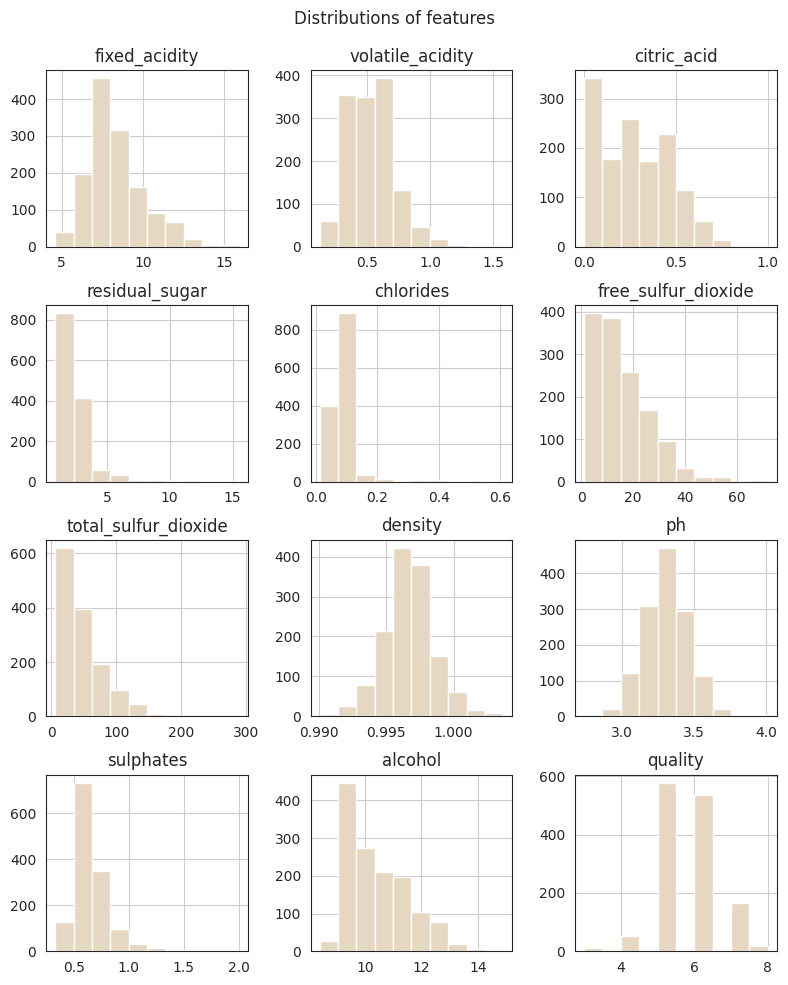

In [13]:
ax = pd.DataFrame.hist(wine, figsize=[8, 10])
plt.tight_layout()
plt.suptitle("Distributions of features")
plt.subplots_adjust(top=0.92)

As we don't want to exclude too many cases in order to not lose too much information, we will not remove any cases that seem outliers but in fact have realistic values for the features in question. After having done some research, no cases will be taken out based on residual sugar levels [1](https://winemakermag.com/technique/501-measuring-residual-sugar-techniques#:~:text=Residual%20Sugar%20Concentration,-Residual%20sugar%20concentration&text=Dry%20wines%20are%20typically%20in,the%205.0%E2%80%9315%20percent%20range), chloride [2](https://www.scielo.br/j/cta/a/HQsrPrPMNZYgRzSKtrjHyHh/?format=pdf), sulfur dioxide and sulphates [3](https://www.oiv.int/public/medias/7840/oiv-collective-expertise-document-so2-and-wine-a-review.pdf). Instead we will assess outliers to the regression line later on.

There are two variables that will be used as target variables in this analysis, therefore we look at their distributions and frequency tables separately.

#### Target features

In [14]:
wine["id"] = range(1, len(wine) + 1)

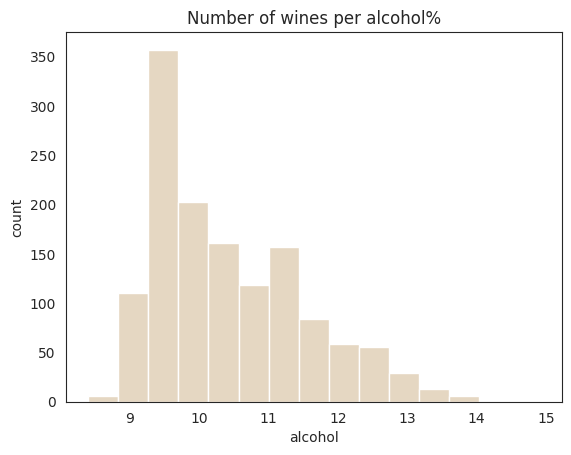

In [15]:
plt.hist(wine["alcohol"], bins=15)
plt.ylabel("count")
plt.xlabel("alcohol")
plt.title("Number of wines per alcohol%")

* We can see the distribution of alcohol is right-skewed, with percentages on the lower end, around 9.5 most common.
* Alcohol percentages outside the 9 to 13% range seem very uncommon.
Below we look at the spread of quality levels.

In [16]:
quality_freq = (
    wine.groupby("quality")[["id"]].count().rename(columns={"id": "frequency"})
)
quality_freq["proportion"] = quality_freq["frequency"] / wine.shape[0]
quality_freq

,frequency,proportion
quality,,
3,10,0.007
4,53,0.039
5,577,0.425
6,535,0.394
7,167,0.123
8,17,0.013


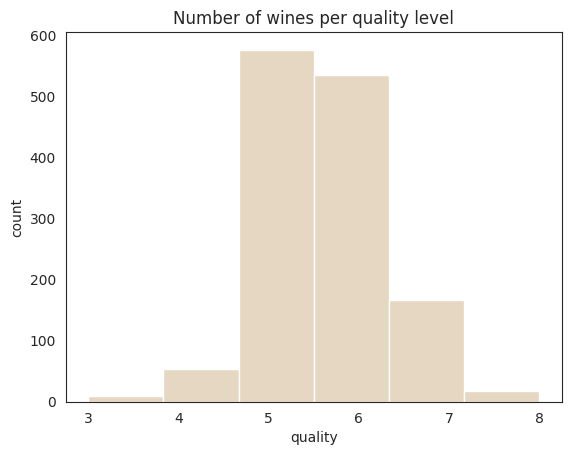

In [17]:
plt.hist(wine["quality"], bins=6)
plt.ylabel("count")
plt.xlabel("quality")
plt.title("Number of wines per quality level")

Quality levels 5 and 6 are clearly most common, 7 is still present to some degree, the other categories are each making up for less than 4% of all wines.

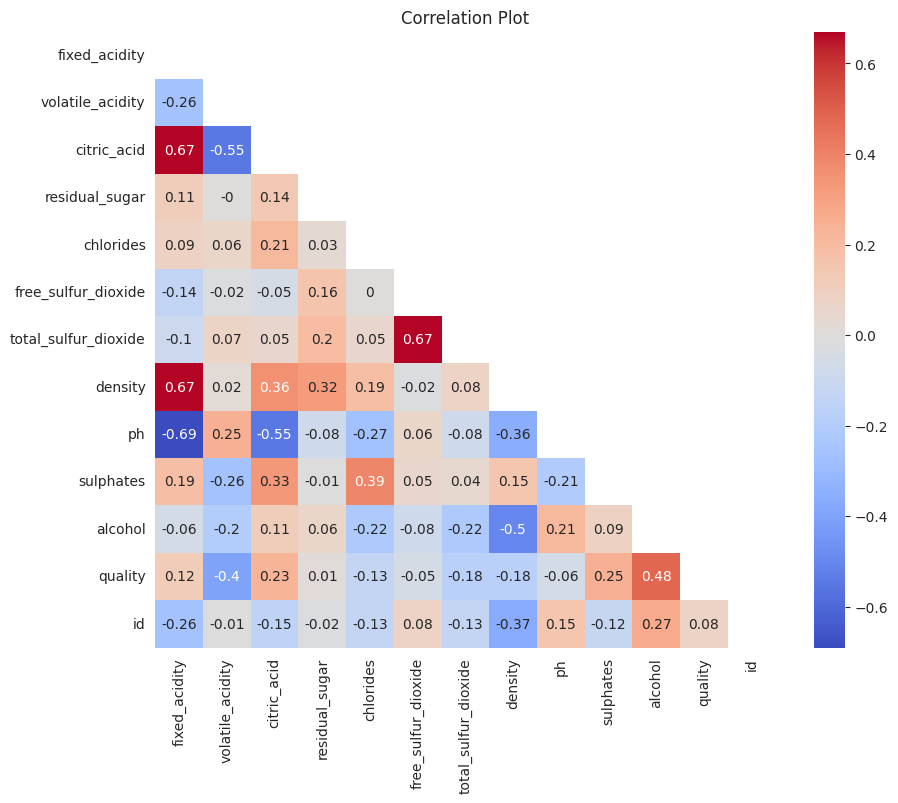

In [18]:
plt.figure(figsize=(10, 8))
corr_matrix = wine.corr().round(2)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap="coolwarm", annot=True)
plt.title("Correlation Plot")
plt.show()

* There are a few correlations of 0.7 and a few 0.5, at which we will take a closer look later. The majority of features has no or a very low correlation.
* Alcohol seems to be the feature strongest related to quality with a correlation of 0.5, we will investigate the direction of this relation next.

In [19]:
wine.to_csv("wine_for_dashboard.csv", index=False)

## Part 2: Statistical tests

### Quality level comparison - Anova

* We have only one categorical feature in the dataset: quality, consisting of 6 ordinal categories.
* Alcohol is the feature most correlated to quality.
* We might wonder therefore how these features relate to each other. First, we want to find out if quality levels differ significantly from each other in alcohol content? For this we will run an Anova.

In [20]:
alc_per_qlevel = wine.groupby("quality")[["alcohol"]].mean()
alc_per_qlevel.rename(columns={"alcohol": "mean alcohol%"})

,mean alcohol%
quality,
3,9.955
4,10.265
5,9.889
6,10.659
7,11.491
8,12.159


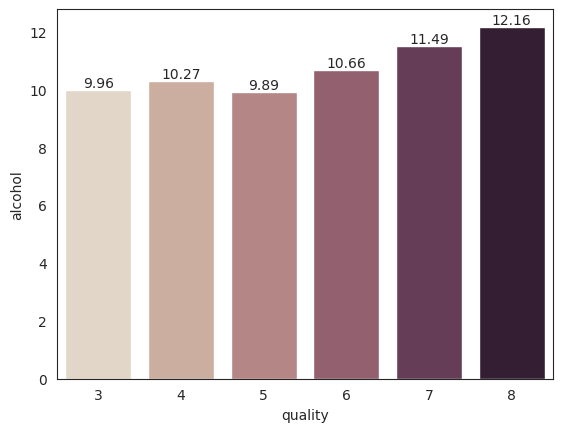

In [21]:
alc_per_qlevel["alcohol"] = alc_per_qlevel["alcohol"].round(2)
ax = sns.barplot(x=alc_per_qlevel.index, y=alc_per_qlevel["alcohol"])
for i, v in enumerate(alc_per_qlevel["alcohol"]):
    ax.text(i, v, str(v), ha="center", va="bottom", fontsize=10)

* The relation seems a positive linear one, however quality level 5 is breaking the trend and is actually lowest in alcohol.
* Thus, the highest quality wines seem to have highest alcohol %, but the lowest quality does not have the lowest alcohol %. However, we are looking at averages, we can doublecheck how spread the values in each quality category are.  

In [22]:
anova_quality = smf.ols("alcohol ~ quality", data=wine).fit()
aov_table = anova_lm(anova_quality, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
quality,366.868,1.000,407.008,0.000
Residual,"1,223.168","1,357.000",NaN,NaN


In [23]:
tukey_results = pairwise_tukeyhsd(
    endog=wine["alcohol"], groups=wine["quality"], alpha=0.05
)
print(tukey_results.summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     3      4   0.3101 0.9257 -0.5971 1.2173  False
     3      5  -0.0664 0.9999 -0.9057 0.7729  False
     3      6   0.7039 0.1598  -0.136 1.5437  False
     3      7   1.5361    0.0  0.6794 2.3928   True
     3      8   2.2038    0.0  1.1551 3.2525   True
     4      5  -0.3765 0.0512 -0.7542 0.0012  False
     4      6   0.3938 0.0363  0.0149 0.7727   True
     4      7    1.226    0.0  0.8112 1.6409   True
     4      8   1.8937    0.0  1.1603 2.6272   True
     5      6   0.7703    0.0  0.6124 0.9282   True
     5      7   1.6026    0.0  1.3713 1.8338   True
     5      8   2.2703    0.0  1.6227 2.9178   True
     6      7   0.8322    0.0   0.599 1.0655   True
     6      8   1.4999    0.0  0.8517 2.1482   True
     7      8   0.6677 0.0513 -0.0022 1.3376  False
---------------------------------------------------


We can see that the average alcohol percentage differs between most levels. However as expected from our graph above, level 3 does not differ from levels 4, 5 and 6 respectively. 4 and 5 also don't differ from each other, and 7 and 8 do not differ significantly from each other.
Therefore, we might be able the wines into two groups, 7 and 8 on the one hand, and level 3 to 6 on the other hand.

### Low/high quality - t-test

We might wonder from the above numbers whether we can really say that higher quality wines on average, are higher in alcohol than lower quality ones. In other words, can we treat them as two distinct groups based on their alcohol content? We will investigate below with an independent samples t-test.

H0: High and low quality wines do not differ in their average alcohol%.

H1: High and low quality wines differ in their average alcohol%.

alpha = 0.05

In [24]:
wine["quality_binary"] = np.where(wine["quality"].isin([3, 4, 5, 6]), 0, 1)
wine["quality_binary"].value_counts()

0    1175
1     184
Name: quality_binary, dtype: int64

In [25]:
qlow = wine[wine["quality_binary"] == 0].sample(n=184, random_state=22)
qhigh = wine[wine["quality_binary"] == 1]
q_merged = pd.concat([qlow, qhigh], axis=0)

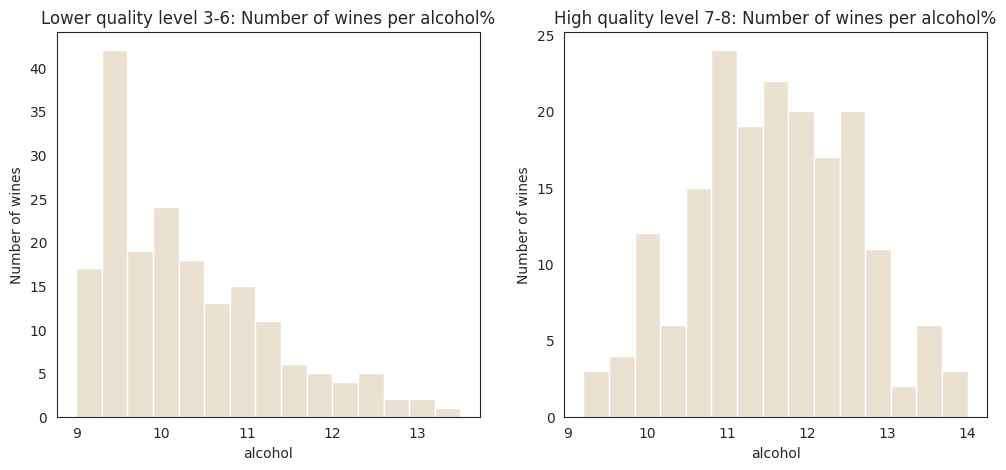

In [26]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(x=qlow["alcohol"], bins=15)
plt.title("Lower quality level 3-6: Number of wines per alcohol%")
plt.ylabel("Number of wines")
plt.subplot(1, 2, 2)
sns.histplot(x=qhigh["alcohol"], bins=15)
plt.title("High quality level 7-8: Number of wines per alcohol%")
plt.ylabel("Number of wines")

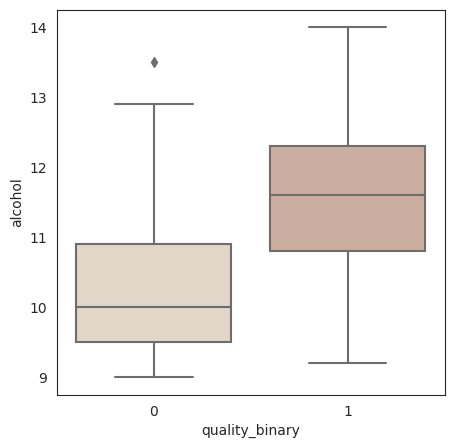

In [27]:
plt.figure(figsize=(5, 5))
sns.boxplot(x="quality_binary", y="alcohol", data=q_merged)

In [28]:
descr_stats = q_merged.groupby("quality_binary")["alcohol"]
std_p = lambda x: np.std(x, ddof=1)  # Std. deviation population param unknown
se_p = lambda x: stats.sem(x, ddof=1)  # Std. error

descr_stats = descr_stats.agg([np.mean, std_p, se_p])
descr_stats.columns = ["mean alcohol%", "std deviation", "std error"]
descr_stats.style.format("{:.3f}")

,mean alcohol%,std deviation,std error
quality_binary,,,
0,10.268,0.964,0.071
1,11.553,1.012,0.075


In [29]:
qlow_alc = qlow["alcohol"]
qhigh_alc = qhigh["alcohol"]

In [30]:
alpha = 0.05
t_stat, p_value = stats.ttest_ind(
    qlow_alc, qhigh_alc, equal_var=True, alternative="less"
)
std_error = np.sqrt(
    np.var(qlow_alc, ddof=1) / len(qlow_alc)
    + np.var(qhigh_alc, ddof=1) / len(qhigh_alc)
)
df = len(qlow_alc) + len(qhigh_alc) - 2
mean_difference = np.mean(qlow_alc) - np.mean(qhigh_alc)
conf_int = stats.t.interval(0.95, df, loc=mean_difference, scale=std_error)

print(f"Difference in Means: {mean_difference:.4f}")
print(
    f"Confidence Interval for the Difference in Means: ({conf_int[0]:.4f}, {conf_int[1]:.4f})\n"
)
print(f"t-statistic: {t_stat:.2f}")
print(f"p-value: {p_value:.4f}\n")

Difference in Means: -1.2843
Confidence Interval for the Difference in Means: (-1.4869, -1.0817)

t-statistic: -12.47
p-value: 0.0000



Our groups are differing significantly from each other, even at a signficance level of 0.01. We can be 95% sure that the difference between low and high quality wines, in their average alcohol%, lies between -1.49 and -1.08 when resampling.
Thus, we can treat them as two distinct groups.

What we are curious about now, is whether we might be able to create a classifier that can predict whether a wine sample is low or high quality by itself.

## Part 3: Data modeling

### Logistic regression predicting quality

As we noticed earlier, the higher quality wines on average have higher alcohol levels. We can split our data in two quality categories which differ significantly in their alcohol percentages, and these categories represent higher and lower quality levels.
Now we would like to find out how well we can predict (binary) quality of a wine from the alcohol content alone.


In [31]:
wine["quality_binary"].value_counts()

0    1175
1     184
Name: quality_binary, dtype: int64

As we see, our classes are highly imbalanced, only about 15% of cases classifies as high quality. To prevent the model from mispredicting all cases as 0's (imbalanced model in appendix), we will upsample class 1 labeled cases, by creating new records that are similar but not identical to existing records, using smote.

Alternatively, weights could be applied to balance classes, results turned out similar, see appendix.

#### Single feature model

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    wine["alcohol"], wine["quality_binary"], test_size=0.2, random_state=2
)
print("n training set: ", len(X_train))
print("n test set: ", len(X_test))

n training set:  1087
n test set:  272


In [33]:
indp = np.array(X_train).reshape(-1, 1)
dep = np.array(y_train)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(indp, dep)
print("n upsampled cases training set :", len(X_resampled))
print("n class 1 labeled cases: ", y_resampled.sum())

n upsampled cases training set : 1872
n class 1 labeled cases:  936


In [34]:
logistic_model2 = LogisticRegression(solver="liblinear", random_state=0).fit(
    X_resampled, y_resampled
)
print(logistic_model2.intercept_)
print(logistic_model2.coef_)

[-9.65172702]
[[0.89538388]]


In [35]:
predicted_probabilities2 = logistic_model2.predict_proba(X_resampled)
predicted_labels2 = logistic_model2.predict(X_resampled)
y_prob1 = predicted_probabilities2[:, 1]

In [36]:
def logistic_evaluation(lm_model_name, x, y, pred_labels):
    cm = confusion_matrix(y, pred_labels)
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.imshow(cm)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1), ticklabels=("Predicted 0s", "Predicted 1s"))
    ax.yaxis.set(ticks=(0, 1), ticklabels=("Actual 0s", "Actual 1s"))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="white")

    accuracy = lm_model_name.score(x, y)
    print("Accuracy: {:.2f}\n".format(accuracy))
    print("Classification report:\n", classification_report(y, pred_labels))


def ROC_AUC(y, prob_y):
    fpr, tpr, thresholds = roc_curve(y, prob_y, pos_label=1)
    roc_df = pd.DataFrame({"recall": tpr, "specificity": 1 - fpr})

    ax = roc_df.plot(x="specificity", y="recall", figsize=(4, 4), legend=False)
    ax.set_ylim(0, 1)
    ax.set_xlim(1, 0)
    ax.plot((1, 0), (0, 1))
    ax.set_xlabel("specificity")
    ax.set_ylabel("recall")
    ax.set_title("ROC curve")

    AUC = roc_auc_score([1 if yi == 1 else 0 for yi in y], prob_y)
    print("AUC: {:.2f}\n".format(AUC))

Accuracy: 0.74

Classification report:
               precision    recall  f1-score   support

           0       0.75      0.72      0.74       936
           1       0.73      0.76      0.75       936

    accuracy                           0.74      1872
   macro avg       0.74      0.74      0.74      1872
weighted avg       0.74      0.74      0.74      1872



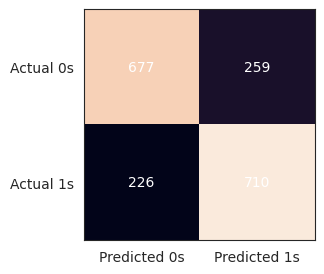

In [37]:
logistic_evaluation(logistic_model2, X_resampled, y_resampled, predicted_labels2)

* The model reaches an accuracy of 74% on the training data, which seems not very good meaning 1 out of 4 cases gets mispredicted.
* Instead of just looking at the rate of correct predictions like we did with accuracy, we might want to take true positive and false negative rates into account when judging performance. Below plotted against each other.

AUC: 0.82



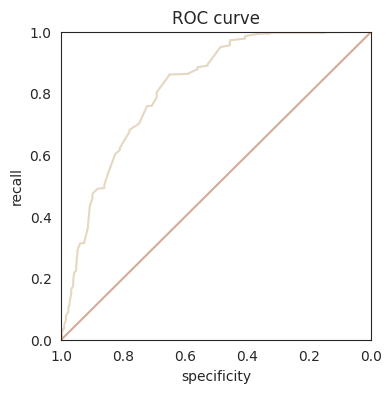

In [38]:
ROC_AUC(y_resampled, y_prob1)

The ROC curve above is showing the trade-off between true postives and false postives. The AUC is 0.82, thus judged by this metric, our model can discriminate between 0's and 1's quite well, at least better than at random.

##### Test data

We will now run the model on the test data that was kept out. This data was not balanced artifically.

In [39]:
X_test = np.array(X_test).reshape(-1, 1)
predicted_labels_test = logistic_model2.predict(X_test)
predicted_probabilities_test = logistic_model2.predict_proba(X_test)
y_prob1_test = predicted_probabilities_test[:, 1]

Accuracy: 0.72

Classification report:
               precision    recall  f1-score   support

           0       0.99      0.69      0.81       239
           1       0.30      0.94      0.45        33

    accuracy                           0.72       272
   macro avg       0.64      0.81      0.63       272
weighted avg       0.90      0.72      0.77       272



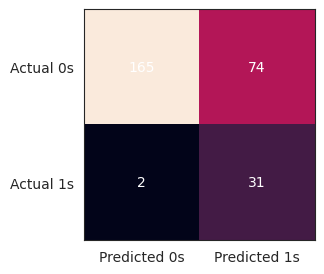

In [40]:
logistic_evaluation(logistic_model2, X_test, y_test, predicted_labels_test)

The model seems good at classifying actual 1's as 1's, recall is higher than on the training set. However, a lot of zeros get mispredicted as 1's, out of the total predicted 1's, only 30% is actually zero. This precision is quite a lot lower than on the training set where it was 73%.  
We might wonder whether this has something to do with the training data being balanced artificially, while the test data is imbalanced.

AUC: 0.87



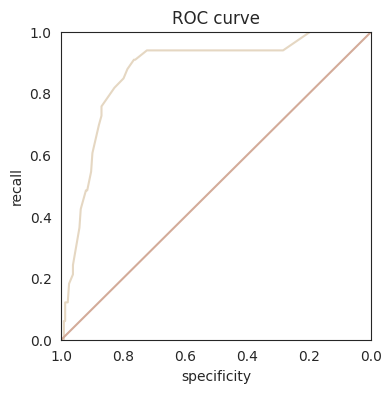

In [41]:
ROC_AUC(y_test, y_prob1_test)

In terms of AUC, the model seems to perform a bit better on the test data than on the training data, 0.87 vs 0.82, which is not expected. This might be due to the small size of the dataset, or the differences in pre-processing.  

#### All feature model

Now we could wonder if the other features in the dataset can contribute to predicting quality. First, we will rescale the dataset.  

In [42]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(wine)
wine_scaled = pd.DataFrame(data=scaled_data, columns=wine.columns)

In [43]:
x_revised8 = wine[
    [
        "fixed_acidity",
        "volatile_acidity",
        "citric_acid",
        "residual_sugar",
        "chlorides",
        "free_sulfur_dioxide",
        "total_sulfur_dioxide",
        "density",
        "ph",
        "sulphates",
        "alcohol",
    ]
]
y_revised8 = wine["quality_binary"]

In [44]:
scaler = MinMaxScaler()
standardized_values = scaler.fit_transform(x_revised8)
x_revised8_scaled = pd.DataFrame(standardized_values, columns=x_revised8.columns)

In [45]:
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    x_revised8_scaled, y_revised8, test_size=0.2, random_state=2
)

smote = SMOTE(random_state=42)
X_resampled_all, y_resampled_all = smote.fit_resample(X_train_all, y_train_all)
logistic_model3 = LogisticRegression(solver="liblinear", random_state=0).fit(
    X_resampled_all, y_resampled_all
)

In [46]:
predicted_probabilities_all = logistic_model3.predict_proba(X_resampled_all)
predicted_labels_all = logistic_model3.predict(X_resampled_all)
y_prob1_all = predicted_probabilities_all[:, 1]

In [47]:
def confusion_plot(cm):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.imshow(cm)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1), ticklabels=("Predicted 0s", "Predicted 1s"))
    ax.yaxis.set(ticks=(0, 1), ticklabels=("Actual 0s", "Actual 1s"))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="white")

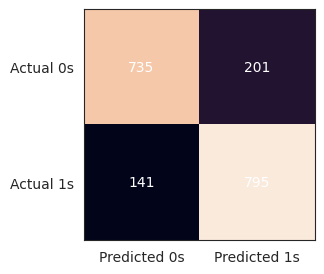

In [48]:
cm_all = confusion_matrix(y_resampled_all, predicted_labels_all)
confusion_plot(cm_all)

In [49]:
accuracy = logistic_model3.score(X_resampled_all, y_resampled_all)
print("Accuracy with training data: {:.2f}".format(accuracy))

Accuracy with training data: 0.82


The model reaches an accuracy of 82% on the training data, which is a bit higher than the 74 and 72% for the single feature model.

In [50]:
print(
    "Classification report:\n",
    classification_report(y_resampled_all, predicted_labels_all),
)

Classification report:
               precision    recall  f1-score   support

           0       0.84      0.79      0.81       936
           1       0.80      0.85      0.82       936

    accuracy                           0.82      1872
   macro avg       0.82      0.82      0.82      1872
weighted avg       0.82      0.82      0.82      1872



AUC: 0.89



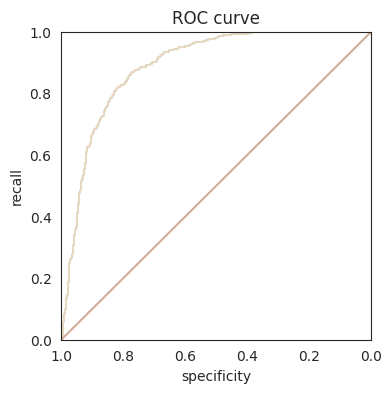

In [51]:
ROC_AUC(y_resampled_all, y_prob1_all)

The AUC is also higher than for the single feature model.

##### Test data

In [52]:
predicted_probabilities_all_test = logistic_model3.predict_proba(X_test_all)
predicted_labels_all_test = logistic_model3.predict(X_test_all)
y_prob1_all_test = predicted_probabilities_all_test[:, 1]

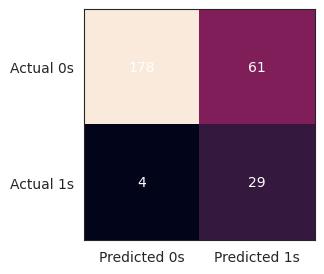

In [53]:
cm_all_test = confusion_matrix(y_test_all, predicted_labels_all_test)
confusion_plot(cm_all_test)

In [54]:
accuracy = logistic_model3.score(X_test_all, y_test_all)
print("Accuracy with training data: {:.2f}".format(accuracy))

Accuracy with training data: 0.76


The model reaches an accuracy of 76% on the test data, a bit lower than on the training data.

In [55]:
print(
    "Classification report:\n",
    classification_report(y_test_all, predicted_labels_all_test),
)

Classification report:
               precision    recall  f1-score   support

           0       0.98      0.74      0.85       239
           1       0.32      0.88      0.47        33

    accuracy                           0.76       272
   macro avg       0.65      0.81      0.66       272
weighted avg       0.90      0.76      0.80       272



Again when running the model on the test data, the precision of predicted 1's is only about 30%, which happened also on the test data for the single feature model.

AUC: 0.89



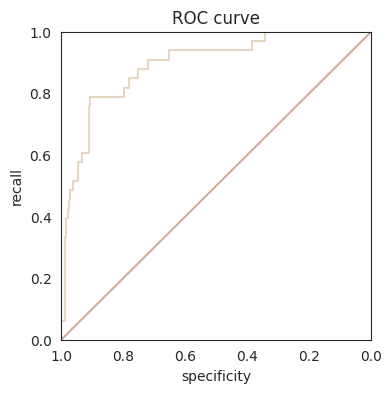

In [56]:
ROC_AUC(y_test_all, y_prob1_all_test)

The AUC of 0.89 is equal to the training data, and a bit better than for the single feature model, which scored 0.82 on the training data and 0.87 on the test data.

However, considering we added ten features this does not seem a big improvement in fit. This is not so surprising as we based the group split on alcohol only, and not on any other feature, plus as we saw earlier most other features have no correlation with quality.  
What might be more interesting, is to find out whether and how the ten added features are related to alchohol.

### Linear regression predicting alcohol

* Which features/feature combinations have most predictive value in a regression model aiming to predict alcohol percentage?
* How accurately is our model predicting?

#### All feature model

Here, the relationships between alcohol and other physicochemical features are investigated further with linear regression model.

Target population: Portuguese "Vinho Verde" red wines
Significance level: 0.05

Assumptions check for linear regression:

* Normally distributed residuals, has been checked in exploratory analysis.
* Observations are independent from each other, each case is a different wine sample.
* Features having a linear relation with the target, will be checked below.
* Multicollinearity among the independent variables will be checked below.
* Homoscedasticity, do the residuals have constant variation against target values? This will be checked later on.

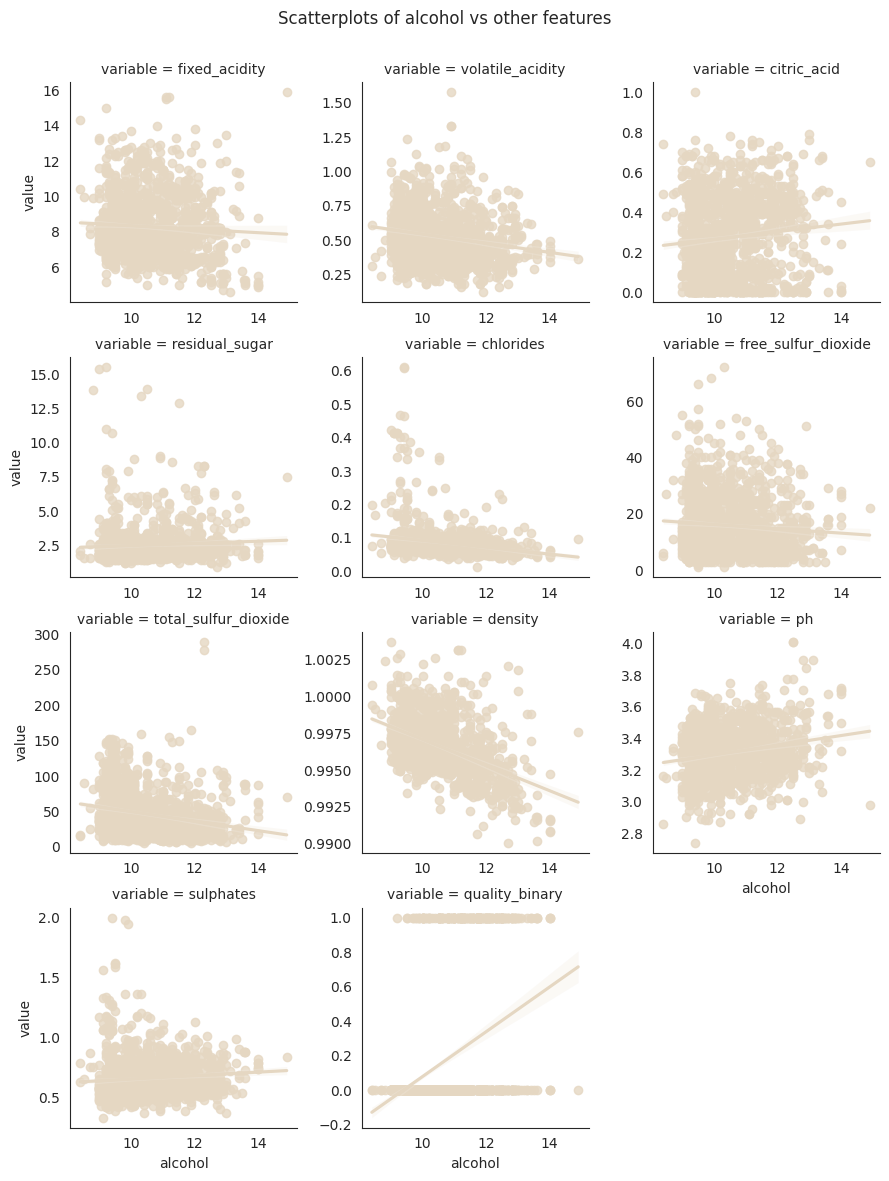

In [98]:
columns_to_drop = ["id", "quality"]
dfm = wine.drop(columns=columns_to_drop, axis=1, inplace=True)
dfm = pd.melt(wine, id_vars=["alcohol"])
g = sns.FacetGrid(
    dfm,
    col="variable",
    col_wrap=3,
    sharex=False,
    sharey=False,
)
g.map(
    sns.regplot,
    "alcohol",
    "value",
)
plt.suptitle("Scatterplots of alcohol vs other features")
plt.subplots_adjust(top=0.92)

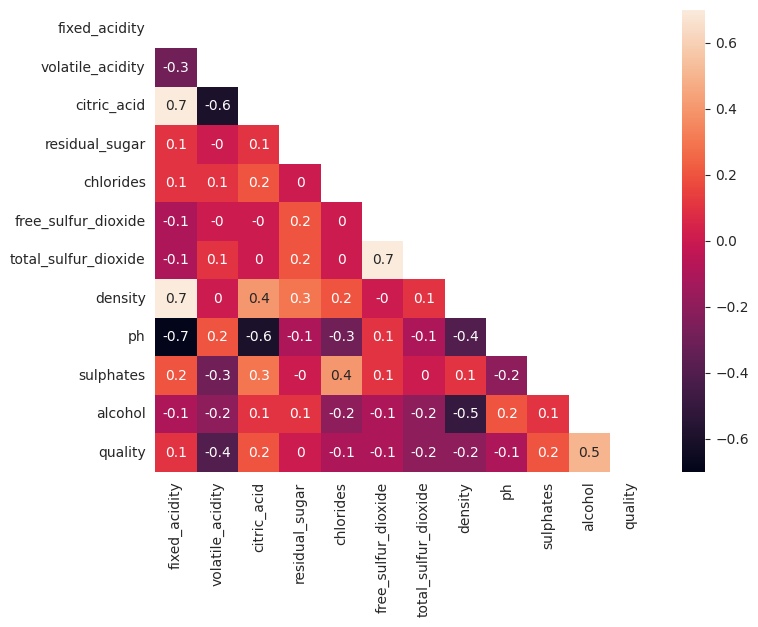

In [57]:
plt.figure(figsize=(8, 6))
corr_vars = wine.drop(["id", "quality_binary"], axis=1)
corr_matrix = corr_vars.corr().round(1)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True)
plt.show()

* Citric acid has high correlations with both fixed acidity and volatile acidity, and also with ph.  
* Fixed acidity has high correlations with critic acid and with both ph and density.
* Free sulfur dioxide and total sulfur dioxide are correlated at 0.7

Looking at the theory and feature definitions:
* Fixed acidity, volatile acidity, citric acid and ph are all measuring acid levels. We can distinguish between volatile and non-volatile acidity, of which fixed acidity is said to be measuring the total level of non-volatile acid. Looking at the correlation plot, citric acid and ph have high correlations with it, whereas volatile acidity doesn't.
* Total sulfur dioxide is measuring all sulfur dioxide of which free sulfur dioxide is part, thus we can keep the former if we want to maximise explanatory power. Sulphates are said to also be sulfur dioxide, however it is not correlated with the latter 2, therefore we won't eliminate it.  

For more detailed comparison of features, use this [dashboard](https://lookerstudio.google.com/reporting/c502df10-4e89-4d79-a5ab-7f948d605d80)

In [90]:
# model 1: all features
x_all = wine[
    [
        "fixed_acidity",
        "volatile_acidity",
        "citric_acid",
        "residual_sugar",
        "chlorides",
        "free_sulfur_dioxide",
        "total_sulfur_dioxide",
        "density",
        "ph",
        "sulphates",
    ]
]
y_all = wine["alcohol"]

In [91]:
scaler = StandardScaler()
standardized_values = scaler.fit_transform(x_all)
x_all_scaled = pd.DataFrame(
    standardized_values, columns=x_all.columns, index=x_all.index
)
x_all_scaled = sm.add_constant(x_all_scaled)

In [71]:
def calc_vif(X):
    vif_table = pd.DataFrame()
    vif_table["feature"] = X.columns
    vif_table["VIF"] = [
        variance_inflation_factor(X.values, i) for i in range(X.shape[1])
    ]
    return vif_table


calc_vif(x_all_scaled)

,feature,VIF
0,const,1.000
1,fixed_acidity,5.478
2,volatile_acidity,1.770
3,citric_acid,3.072
4,residual_sugar,1.226
5,chlorides,1.520
6,free_sulfur_dioxide,1.950
7,total_sulfur_dioxide,2.200
8,density,2.643
9,ph,2.471


Fixed_acidity seems to have the highest VIF, looking at the correlation matrix we notice that it has a (-)0.7 correlation with three other features, making it the feature most strongly correlated to the other features.

In [92]:
alcohol_pred = sm.OLS(y_all, x_all_scaled).fit()
print(alcohol_pred.summary())

                            OLS Regression Results                            
Dep. Variable:                alcohol   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     288.6
Date:                Thu, 28 Dec 2023   Prob (F-statistic):               0.00
Time:                        19:34:39   Log-Likelihood:                -1257.3
No. Observations:                1359   AIC:                             2537.
Df Residuals:                    1348   BIC:                             2594.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   10.4323 

When first using all features in our model as explanatory variables, the r squared is a quite reasonable 0.68. This would mean that 68% of the variation in alcohol percentages of the wines in our dataset, could be explained by the features in our model.
Except for free_sulfur_dioxide, all features have a significant effect on the target feature, alpha < 0.05

We are curious now as to whether the model fit will improve if taking out fixed_acidity because of its correlations.

In [103]:
# model 2 taking out fixed_acidity
x_revised2 = x_all_scaled[
    [
        "citric_acid",
        "ph",
        "volatile_acidity",
        "residual_sugar",
        "chlorides",
        "total_sulfur_dioxide",
        "free_sulfur_dioxide",
        "density",
        "sulphates",
    ]
]
y_revised2 = wine["alcohol"]

x_revised2 = sm.add_constant(x_revised2)

alcohol_pred2 = sm.OLS(y_revised2, x_revised2).fit()
print(alcohol_pred2.summary())

                            OLS Regression Results                            
Dep. Variable:                alcohol   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     177.4
Date:                Thu, 28 Dec 2023   Prob (F-statistic):          1.50e-221
Time:                        20:03:09   Log-Likelihood:                -1504.4
No. Observations:                1359   AIC:                             3029.
Df Residuals:                    1349   BIC:                             3081.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   10.4323 

Model fit does not improve, but actually is 14% lower. We might try to take out the features that fixed_acidity was correlated with and put fixed_acidity back in.

In [105]:
# model 3 taking out citric acid and ph
x_revised3 = x_all_scaled[
    [
        "fixed_acidity",
        "volatile_acidity",
        "residual_sugar",
        "chlorides",
        "total_sulfur_dioxide",
        "free_sulfur_dioxide",
        "density",
        "sulphates",
    ]
]
y_revised3 = wine["alcohol"]

x_revised3 = sm.add_constant(x_revised3)

alcohol_pred3 = sm.OLS(y_revised3, x_revised3).fit()
print(alcohol_pred3.summary())

                            OLS Regression Results                            
Dep. Variable:                alcohol   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     209.2
Date:                Thu, 28 Dec 2023   Prob (F-statistic):          3.44e-230
Time:                        20:06:05   Log-Likelihood:                -1487.0
No. Observations:                1359   AIC:                             2992.
Df Residuals:                    1350   BIC:                             3039.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   10.4323 

Model fit is roughly the same as for the previous model. What's remarkable is that volatile_acidity is not having a significant effect on the target any more after taking out the ph and citric acid features.

Thus, we will just keep all features in, since altogehter they reach the highest r-squared.

#### Coefficient interpretation

Looking at the coefficients in our model, we notice that most attributes have a positive relation with alcohol, meaning for higher values of the below attributes, the alcohol percentage of wine is likely to be higher:
* residual sugar
* ph
* sulphates
* citric acid
* volatile acidity

Chloride, density and sulfur dioxide are having a negative effect on alcohol, for wines with higher levels of these, alcohol % seems to be lower.

Diving into theory, the direction of the coefficients of these features in our model seems to not always make sense. For example, usually wines with a higher alcohol content are having lower levels of sugar, thus a negative coefficient would be expected instead of the positive one above.
We might wonder whether there are outliers or influential values for this feature that are disturbing the relation.

Alternatively, the relation between alcohol level and the features we have is not linear.
Looking at the scatterplots below, only for density there seem to be signs of a linear relation. It could be that different model types might be a better fit for the relation between most of our features and target.

#### Outliers/residuals
Next we will take a look at outliers to the regression line.

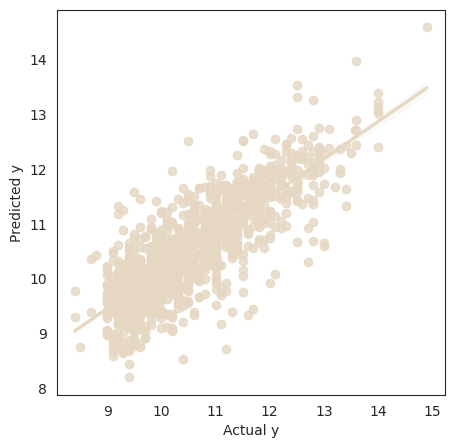

In [108]:
pred_y = np.array(alcohol_pred.fittedvalues)
actual_y = np.array(wine["alcohol"])
plt.figure(figsize=(5, 5))
sns.regplot(x=actual_y, y=pred_y)

plt.ylabel("Predicted y")
plt.xlabel("Actual y")

We can clearly see that our model is having a lot of residuals as the actual and predicted y values by far not always match.

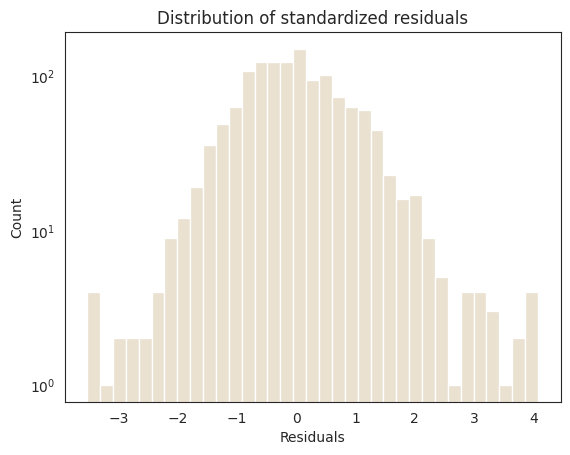

In [109]:
influence = OLSInfluence(alcohol_pred)
sresiduals = influence.resid_studentized_internal
sns.histplot(sresiduals)
plt.yscale("log")
plt.title("Distribution of standardized residuals")
plt.xlabel("Residuals")

* The distribution of standardised residuals in our dataset is pretty symmetric. However, looking at how many predicted values were more than -/+2 se away from the actual values, there are more predictions highly overestimating the alcohol level than highly  underestimating it.
* Looking at the min and max of our plot, it seems like there are a few predicted values for our target with values more than 4 or -4 standard errors away from the observed values.


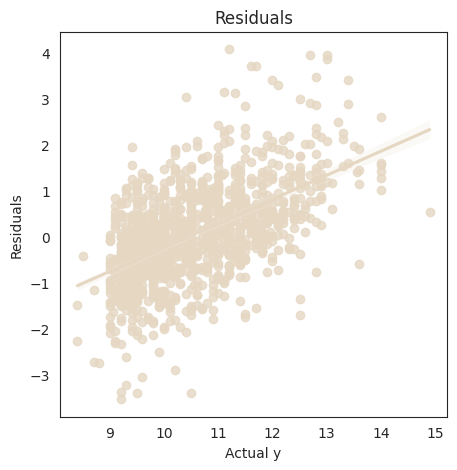

In [110]:
plt.figure(figsize=(5, 5))
sns.regplot(x=actual_y, y=sresiduals)
plt.xlabel("Actual y")
plt.ylabel("Residuals")
plt.title("Residuals")

It seems like the alcohol% is more often underestimated for lower alcohol wines, and more often overestimated for wines higher in alcohol.

#### Influential values
We now want to find out whether any of the outliers are influential, as in, able to significantly change the regression equation.

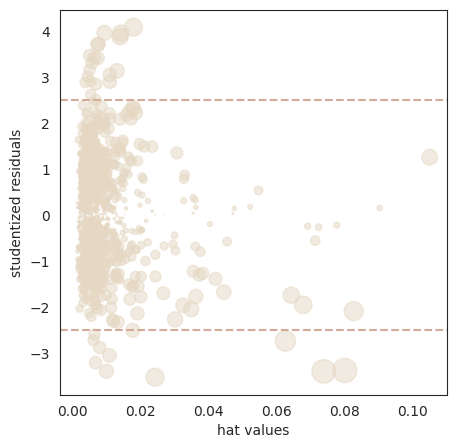

In [111]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.axhline(-2.5, linestyle="--", color="C1")
ax.axhline(2.5, linestyle="--", color="C1")
ax.scatter(
    influence.hat_matrix_diag,
    influence.resid_studentized_internal,
    s=1000 * np.sqrt(influence.cooks_distance[0]),
    alpha=0.5,
)
ax.set_xlabel("hat values")
ax.set_ylabel("studentized residuals")

 The hat values are plotted on the x-axis, the residuals are plotted on the y-axis, and the size of the points is related to the value of Cook’s distance.
 We notice there are two datapoints in the lower right corner that are high on all three metrics. We will take a closer look at those.

In [112]:
cook_distance = influence.cooks_distance[0]
threshold = 4 / (len(wine["alcohol"]))  # A commonly used threshold
influential_values = cook_distance > threshold

In [121]:
influential_values = pd.DataFrame(influential_values)
influential_values = influential_values[influential_values[0] == True]
infl = influential_values.index
wine_scaled_todrop = wine[wine.index.isin(infl)]
wine_scaled_todrop.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality_binary
count,84.000,84.000,84.000,84.000,84.000,84.000,84.000,84.000,84.000,84.000,84.000,84.000
mean,9.196,0.540,0.380,3.987,0.108,18.357,52.869,0.998,3.283,0.752,11.030,0.143
std,2.759,0.259,0.227,3.414,0.096,14.527,35.461,0.003,0.235,0.282,1.521,0.352
min,5.000,0.180,0.000,0.900,0.012,3.000,6.000,0.990,2.740,0.390,8.400,0.000
25%,6.975,0.340,0.217,1.950,0.066,6.750,23.000,0.996,3.120,0.560,9.575,0.000
50%,8.900,0.495,0.380,2.700,0.076,14.500,46.500,0.998,3.275,0.690,10.950,0.000
75%,11.325,0.666,0.502,4.300,0.104,24.500,79.500,1.000,3.415,0.820,12.350,0.000
max,15.600,1.580,1.000,15.500,0.610,72.000,160.000,1.004,4.010,2.000,14.000,1.000


There appear to be 84 cases that could be seen as influential.

In [ ]:
wine_rev = wine.drop(infl)

In [123]:
# final model: without influential values
x_all_rev = wine_rev[
    [
        "fixed_acidity",
        "volatile_acidity",
        "citric_acid",
        "residual_sugar",
        "chlorides",
        "free_sulfur_dioxide",
        "total_sulfur_dioxide",
        "density",
        "ph",
        "sulphates",
    ]
]
y_all_rev = wine_rev["alcohol"]

In [124]:
scaler = StandardScaler()
standardized_values = scaler.fit_transform(x_all_rev)
x_rev_scaled = pd.DataFrame(
    standardized_values, columns=x_all_rev.columns, index=x_all_rev.index
)
x_rev_scaled = sm.add_constant(x_rev_scaled)

In [125]:
alcohol_pred_final = sm.OLS(y_all_rev, x_rev_scaled).fit()
print(alcohol_pred_final.summary())

                            OLS Regression Results                            
Dep. Variable:                alcohol   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     430.4
Date:                Thu, 28 Dec 2023   Prob (F-statistic):               0.00
Time:                        20:20:33   Log-Likelihood:                -907.96
No. Observations:                1275   AIC:                             1838.
Df Residuals:                    1264   BIC:                             1895.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   10.3930 

R-squared went from 0.68 to 0.77 and thus is higher than our model not corrected for influential values.  

# Part 4: Conclusions

**Data:**

After cleaning, the wine dataset consists of 1359 cases that represent different wines, with information on:
* 11 continuous features: chemical properties plus the alcohol %
* 1 discrete feature indicating quality with 6 levels (3 to 8), of which we don't know the measurement unit.
* Correlations between features: no higher correlations than 0.7 are found.  

**Predicting quality:**

* Alcohol is the feature that is strongest correlated with quality (however still moderate with a correlation of 0.5).  
* After running an Anova we find that quality levels 3 to 6 do not differ from each other, and 7 and 8 neither. Thus we created a binary feature by splitting the levels into 2 groups: high quality versus rest.
* An independent samples t-test shows the two quality categories differ significantly from each other, thus we can use quality_binary as a target variable in a logistic regression.  
* Since group sizes differed a lot, sample imbalance has been corrected with SMOTE.  
* We find that alcohol alone gives an accuracy on the training set of 73% and an AUC of 0.81. Accuracy on test set 72% and an AUC of 0.87, however with a much lower precision.
* A model with all 11 continuous features in the dataset gives an accuracy of 82% and an AUC of 0.89 on the training data and a bit lower accuracy on the test data.

**Predicting alcohol:**

* Linear regression is used to explain variation in alcohol% with the chemical property features in the dataset.
* There were a few moderately correlated features, after taking those out, features only manage to explain 54% of the variance in alcohol via the created model.
* However, as correlation are only around 0.6, we keep all features. If we take out outliers/influential values identified with cook's distance, model fit increases to an r-squared of 0.77, thus the features together explain 77% of the variance in alcohol level.



# Part 5: Limitations & suggestions for further research

Linear regression:
* The % predicted variance for the linear regression models was quite low. Thus we cannot really use them to predict alcohol content in a reliable way.
* To evaluate model fit an compare models with different features, the AIC could have been taken into account.
* We might be missing some features that could explain the remaining variance like type of grape, fermentation time or others. Or potentially a different model than linear regression might do a better job at explaining the relation between our features and the outcome variable, as we saw in our scatterplots that no feature has a clear linear relation.

Logistic regression:
* The binary grouping has been based on alcohol feature only, since most others had only very low correlations.
* Low precision when using test data on the models, could be due to corrected sample imbalance in training data, while test data is still imbalanced (1:6 ratio of 1 and 0). Smote was used to balance the samples. Another method like applying weights to correct sample imbalance might work better.

Dashboard:
* Scaled data might have been the better option, as the dashboard is meant to facilitate the comparison of alcohol levels. However a dashboard would have been more useful if there would have been more categorical variables.  

Further research could be focused on finding out whether features that measure the same/similar concepts could be grouped into overarching concepts via pca, and potentially use those to find clusters in the dataset.

### Appendix

##### Single logistic model with unbalanced samples

In [126]:
logistic_model = LogisticRegression(solver="liblinear", random_state=0).fit(indp, dep)

In [127]:
predicted_probabilities = logistic_model.predict_proba(indp)
predicted_labels = logistic_model.predict(indp)

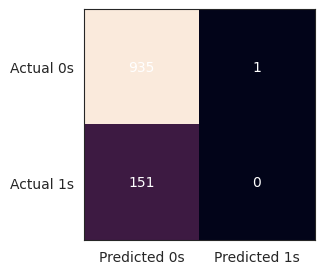

In [128]:
cm = confusion_matrix(dep, predicted_labels)
fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=("Predicted 0s", "Predicted 1s"))
ax.yaxis.set(ticks=(0, 1), ticklabels=("Actual 0s", "Actual 1s"))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="white")

In [129]:
accuracy = logistic_model.score(indp, dep)
print("Accuracy with training data: {:.2f}".format(accuracy))

Accuracy with training data: 0.86


##### Weighted model

Alternatively, to adress the sample imbalance we can give more importance or "weight" to the minority class during model training to prevent the model from being biased towards the majority class.

In [130]:
X = np.array(wine["alcohol"]).reshape(-1, 1)
y = wine["quality_binary"]

p_highq = np.mean(wine.quality_binary == 1)
wt_highq = 1 / p_highq
wt = [wt_highq if quality_binary == 1 else 1 for quality_binary in wine.quality_binary]

weighted_model = LogisticRegression(solver="liblinear", random_state=2).fit(
    X, y, sample_weight=wt
)

print(
    "Percentage of wines predicted to be of high quality: {:.2f}".format(
        100 * np.mean(weighted_model.predict(X) == 1)
    )
)
print(
    "Number of wines predicted to be of high quality: {:.0f}".format(
        weighted_model.predict(X).sum()
    )
)

Percentage of wines predicted to be of high quality: 35.17
Number of wines predicted to be of high quality: 478


In [131]:
pred_ylabels = weighted_model.predict(X)
y_pred = weighted_model.predict_proba(X)
pred_y_array = y_pred[:, 1]

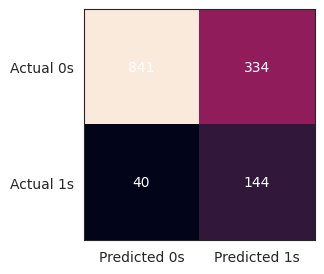

In [132]:
cm_revised = confusion_matrix(y, pred_ylabels)
fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(cm_revised)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=("Predicted 0s", "Predicted 1s"))
ax.yaxis.set(ticks=(0, 1), ticklabels=("Actual 0s", "Actual 1s"))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm_revised[i, j], ha="center", va="center", color="white")

In [133]:
accuracy = weighted_model.score(X, y)
print("Accuracy: {:.2f}".format(accuracy))

Accuracy: 0.72


In [134]:
print(classification_report(y, pred_ylabels))

              precision    recall  f1-score   support

           0       0.95      0.72      0.82      1175
           1       0.30      0.78      0.44       184

    accuracy                           0.72      1359
   macro avg       0.63      0.75      0.63      1359
weighted avg       0.87      0.72      0.77      1359



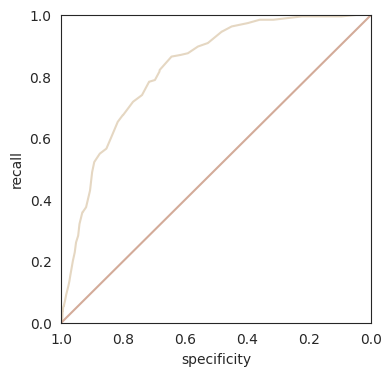

In [135]:
# roc curve
fpr, tpr, thresholds = roc_curve(y, pred_y_array, pos_label=1)
roc_df = pd.DataFrame({"recall": tpr, "specificity": 1 - fpr})

ax = roc_df.plot(x="specificity", y="recall", figsize=(4, 4), legend=False)
ax.set_ylim(0, 1)
ax.set_xlim(1, 0)
ax.plot((1, 0), (0, 1))
ax.set_xlabel("specificity")
ax.set_ylabel("recall")

In [136]:
AUC_weighted = roc_auc_score([1 if yi == 1 else 0 for yi in y], pred_y_array)
print("AUC: {:.2f}".format(AUC_weighted))

AUC: 0.82


##### Logistic with statsmodels

Statsmodels all features

In [137]:
X_resampled_all = sm.add_constant(X_resampled_all)

logistic_model3_sm = sm.GLM(
    y_resampled_all, X_resampled_all, family=sm.families.Binomial()
).fit()
print(logistic_model3_sm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         quality_binary   No. Observations:                 1872
Model:                            GLM   Df Residuals:                     1860
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -769.45
Date:                Thu, 28 Dec 2023   Deviance:                       1538.9
Time:                        20:24:16   Pearson chi2:                 4.50e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4312
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -2.0058 

We can see that three features do not have a significant effect, thus we take them out.

In [138]:
pred_prob_sm = logistic_model3_sm.predict(X_resampled_all)
pred_labels_sm = (pred_prob_sm > 0.5).astype(int)

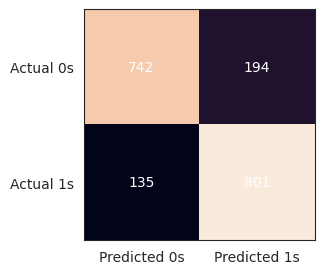

In [139]:
cm = confusion_matrix(y_resampled_all, pred_labels_sm)
fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=("Predicted 0s", "Predicted 1s"))
ax.yaxis.set(ticks=(0, 1), ticklabels=("Actual 0s", "Actual 1s"))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="white")

In [140]:
print(
    "Classification report:\n", classification_report(y_resampled_all, pred_labels_sm)
)

Classification report:
               precision    recall  f1-score   support

           0       0.85      0.79      0.82       936
           1       0.81      0.86      0.83       936

    accuracy                           0.82      1872
   macro avg       0.83      0.82      0.82      1872
weighted avg       0.83      0.82      0.82      1872



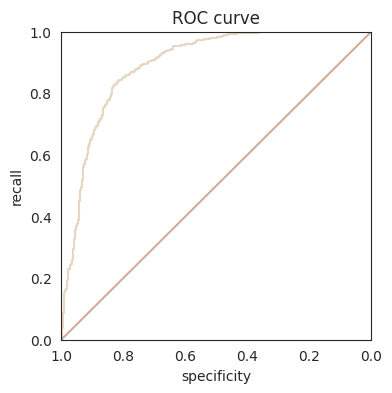

In [141]:
fpr, tpr, thresholds = roc_curve(y_resampled_all, pred_prob_sm, pos_label=1)
roc_df = pd.DataFrame({"recall": tpr, "specificity": 1 - fpr})

ax = roc_df.plot(x="specificity", y="recall", figsize=(4, 4), legend=False)
ax.set_ylim(0, 1)
ax.set_xlim(1, 0)
ax.plot((1, 0), (0, 1))
ax.set_xlabel("specificity")
ax.set_ylabel("recall")
ax.set_title("ROC curve")

In [142]:
AUC_all = roc_auc_score([1 if yi == 1 else 0 for yi in y_resampled_all], pred_prob_sm)
print("AUC: {:.2f}".format(AUC_all))

AUC: 0.89


Reduced model

In [143]:
x_revised9 = wine_scaled[
    [
        "fixed_acidity",
        "volatile_acidity",
        "residual_sugar",
        "chlorides",
        "total_sulfur_dioxide",
        "density",
        "sulphates",
        "alcohol",
    ]
]
y_revised9 = wine_scaled["quality_binary"]
x_revised9 = sm.add_constant(x_revised9)

In [144]:
logistic_model4_sm = sm.GLM(y_revised9, x_revised9, family=sm.families.Binomial())
logit_result4 = logistic_model4_sm.fit()
print(logit_result4.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         quality_binary   No. Observations:                 1359
Model:                            GLM   Df Residuals:                     1350
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -369.24
Date:                Thu, 28 Dec 2023   Deviance:                       738.48
Time:                        20:24:16   Pearson chi2:                 1.15e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2209
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -3.0523 

In [145]:
pred_prob_sm2 = logit_result4.predict(x_revised9)
pred_labels_sm2 = (pred_prob_sm2 > 0.5).astype(int)

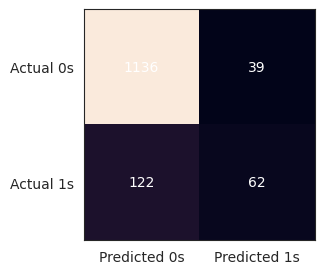

In [146]:
cm = confusion_matrix(y_revised9, pred_labels_sm2)
fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=("Predicted 0s", "Predicted 1s"))
ax.yaxis.set(ticks=(0, 1), ticklabels=("Actual 0s", "Actual 1s"))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="white")

In [147]:
print("Classification report:\n", classification_report(y_revised9, pred_labels_sm2))

Classification report:
               precision    recall  f1-score   support

         0.0       0.90      0.97      0.93      1175
         1.0       0.61      0.34      0.44       184

    accuracy                           0.88      1359
   macro avg       0.76      0.65      0.68      1359
weighted avg       0.86      0.88      0.87      1359



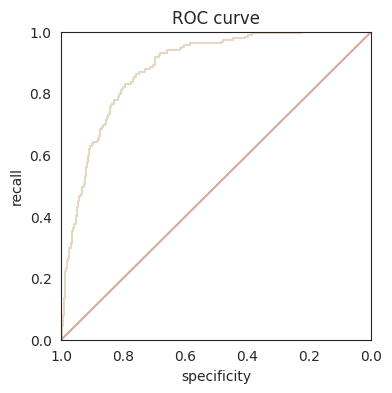

In [148]:
fpr, tpr, thresholds = roc_curve(y_revised9, pred_prob_sm2, pos_label=1)
roc_df = pd.DataFrame({"recall": tpr, "specificity": 1 - fpr})

ax = roc_df.plot(x="specificity", y="recall", figsize=(4, 4), legend=False)
ax.set_ylim(0, 1)
ax.set_xlim(1, 0)
ax.plot((1, 0), (0, 1))
ax.set_xlabel("specificity")
ax.set_ylabel("recall")
ax.set_title("ROC curve")

In [149]:
AUC_all = roc_auc_score([1 if yi == 1 else 0 for yi in y_revised9], pred_prob_sm2)
print("AUC: {:.2f}".format(AUC_all))

AUC: 0.88
